# 第10章: 機械翻訳
*既存のツールを活用し，ニューラル機械翻訳モデルを構築します．*

本章では，日本語と英語の翻訳コーパスである[京都フリー翻訳タスク (KFTT)](http://www.phontron.com/kftt/index-ja.html)を用い，ニューラル機械翻訳モデルを構築する．ニューラル機械翻訳モデルの構築には，[fairseq](https://github.com/pytorch/fairseq)，[HuggingFace Transformers](https://github.com/huggingface/transformers)，[OpenNMT-py](https://github.com/OpenNMT/OpenNMT-py)などの既存のツールを活用せよ．



## 90 データの準備

In [ ]:
#install prerequisite (Transformers, Datasets, and Evaluate libraries)

!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [ ]:
!git config --global user.email "clovis.zhu@gmail.com"
!git config --global user.name "Clovis Zhu"

In [ ]:
#Huggingface login

from huggingface_hub import notebook_login

notebook_login()

In [ ]:
#load datasets
#if the dataset isn't on the Hub, refer to https://huggingface.co/learn/nlp-course/chapter5/2?fw=pt
#use load_dataset("csv", data_files="my_file.csv"), etc.

from datasets import load_dataset

split_datasets = load_dataset("may-ohta/kftt")

In [ ]:
split_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 440289
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 1167
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 1161
    })
    tune: Dataset({
        features: ['translation'],
        num_rows: 1236
    })
})

In [ ]:
split_datasets["train"][1]["translation"]

{'en': 'He revolutionized the Japanese ink painting.', 'ja': '日本の水墨画を一変させた。'}

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-ja-en"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

In [ ]:
!pip install sacremoses

In [ ]:
#try out the tokenizer

en_sentence = split_datasets["train"][1]["translation"]["en"]
ja_sentence = split_datasets["train"][1]["translation"]["ja"]

inputs = tokenizer(ja_sentence, text_target=en_sentence)
inputs

{'input_ids': [1883, 13, 1458, 43384, 4955, 22, 1088, 2423, 843, 88, 5832, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [132, 8414, 3459, 5, 3351, 17809, 11398, 2, 0]}

In [ ]:
print(tokenizer.convert_ids_to_tokens(inputs["labels"]))
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"]))

['▁He', '▁revolution', 'ized', '▁the', '▁Japanese', '▁ink', '▁painting', '.', '</s>']
['▁日本', 'の', '水', '墨', '画', 'を', '一', '変', 'させ', 'た', '。', '</s>']


## 91 機械翻訳モデルの訓練

In [ ]:
#tokenize the datasets

max_length = 128

def preprocess_function(examples):
    inputs = [ex["ja"] for ex in examples["translation"]]
    targets = [ex["en"] for ex in examples["translation"]]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True
    )
    return model_inputs

tokenized_datasets = split_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=split_datasets["train"].column_names,
)

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
#One weakness with BLEU is that it expects the text to already be tokenized,
#which makes it difficult to compare scores between models that use different tokenizers.
#So instead, the most commonly used metric for benchmarking translation models today is SacreBLEU,
#which addresses this weakness (and others) by standardizing the tokenization step.

!pip install sacrebleu

In [ ]:
import evaluate

metric = evaluate.load("sacrebleu") #the Evaluate object will be used to compute sacrebleu scores

In [ ]:
#define the evaluation function, which will be used by the Trainer object

import numpy as np

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # In case the model returns more than the what we need
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True) #token to string

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True) #token to string

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels] #the metric is designed to accept several acceptable targets, so it should be a list of list of strings

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

In [ ]:
#define hyper-parameters

from transformers import Seq2SeqTrainingArguments

args = Seq2SeqTrainingArguments(
    f"marian-finetuned-kftt-ja-to-en",
    evaluation_strategy="no", #don't do evaluation during training
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01, #for regularization (anti over-fitting)
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True, #predict by auto-regressive generation
    fp16=True,
    push_to_hub=True,
)

In [ ]:
#build the Trainer

from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/sephinroth/marian-finetuned-kftt-ja-to-en into local empty directory.


In [ ]:
#evaluate before the training

trainer.evaluate(max_length=max_length)

{'eval_loss': 4.388503074645996,
 'eval_bleu': 5.758647378073413,
 'eval_runtime': 121.8131,
 'eval_samples_per_second': 9.58,
 'eval_steps_per_second': 0.156}

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,3.742400
1000,3.308500
1500,3.119900
2000,2.973200
2500,2.873400
3000,2.807200
3500,2.729900
4000,2.668400
4500,2.607900
5000,2.570200


Adding files tracked by Git LFS: ['source.spm', 'target.spm']. This may take a bit of time if the files are large.


TrainOutput(global_step=41280, training_loss=2.165757581429888, metrics={'train_runtime': 9480.9173, 'train_samples_per_second': 139.318, 'train_steps_per_second': 4.354, 'total_flos': 2.9732754025414656e+16, 'train_loss': 2.165757581429888, 'epoch': 3.0})

In [ ]:
trainer.evaluate(max_length=max_length)

{'eval_loss': 1.955135464668274,
 'eval_bleu': 19.68604320446213,
 'eval_runtime': 111.4727,
 'eval_samples_per_second': 10.469,
 'eval_steps_per_second': 0.17,
 'epoch': 3.0}

In [ ]:
trainer.push_to_hub(tags="translation", commit_message="Training complete")

To https://huggingface.co/sephinroth/marian-finetuned-kftt-ja-to-en
   59cd747..db3879e  main -> main

   59cd747..db3879e  main -> main

To https://huggingface.co/sephinroth/marian-finetuned-kftt-ja-to-en
   db3879e..fa4b132  main -> main

   db3879e..fa4b132  main -> main



'https://huggingface.co/sephinroth/marian-finetuned-kftt-ja-to-en/commit/db3879e434b08566c4f16d0962ca379951e7056a'

## 92 機械翻訳モデルの適用

In [ ]:
from transformers import pipeline

model_checkpoint = "sephinroth/marian-finetuned-kftt-ja-to-en"
translator = pipeline("translation", model=model_checkpoint)

In [ ]:
translator(
    "猫はかわいい。"
)

[{'translation_text': 'Cats are cute.'}]

In [ ]:
translator(
    "七年もあると、人間はたいていの事ができる。"
)

[{'translation_text': 'In seven years, human beings can do most things.'}]

In [ ]:
translator(
    "しかし月日はたちやすいものでね、七年ぐらいじきですよ"
)

[{'translation_text': 'However, the date is easy and it takes about seven years.'}]

In [ ]:
translator_origin = pipeline("translation", model="Helsinki-NLP/opus-mt-ja-en")

In [ ]:
translator_origin("七年もあると、人間はたいていの事ができる。")

[{'translation_text': 'After seven years, humans can do most things.'}]

In [ ]:
translator_origin("しかし月日はたちやすいものでね、七年ぐらいじきですよ")

[{'translation_text': '(Laughter)'}]

## 93 BLEUスコアの計測

In [ ]:
import evaluate
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq

metric = evaluate.load("sacrebleu") #the Evaluate object will be used to compute sacrebleu scores

model_checkpoint = "sephinroth/marian-finetuned-kftt-ja-to-en"
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
#define the evaluation function, which will be used by the Trainer object

import numpy as np

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # In case the model returns more than the what we need
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True) #token to string

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True) #token to string

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels] #the metric is designed to accept several acceptable targets, so it should be a list of list of strings

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

In [ ]:
args = Seq2SeqTrainingArguments(
    f"marian-finetuned-kftt-ja-to-en-test-only",
    evaluation_strategy="no", #don't do evaluation during training
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01, #for regularization (anti over-fitting)
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True, #predict by auto-regressive generation
    fp16=True,
    push_to_hub=False,
)

tester = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
tester.evaluate(max_length=max_length)

{'eval_loss': 1.823565125465393,
 'eval_bleu': 20.454677588521438,
 'eval_runtime': 130.4178,
 'eval_samples_per_second': 8.902,
 'eval_steps_per_second': 0.146}

## 94 ビーム探索

In [ ]:
args = Seq2SeqTrainingArguments(
    f"marian-finetuned-kftt-ja-to-en-test-only",
    evaluation_strategy="no", #don't do evaluation during training
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=8,
    weight_decay=0.01, #for regularization (anti over-fitting)
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True, #predict by auto-regressive generation
    fp16=True,
    push_to_hub=False,
)

validator = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
from tqdm.auto import tqdm

beam_sizes = [1,10,20,30,40,50,60,70,80,90,100]
results = []

for i in tqdm(beam_sizes):
  result = validator.evaluate(max_length=max_length, num_beams=i)
  results.append(result)
  print(result)

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.8983266353607178, 'eval_bleu': 18.431206637226524, 'eval_runtime': 115.3865, 'eval_samples_per_second': 10.114, 'eval_steps_per_second': 1.265}
{'eval_loss': 1.8983266353607178, 'eval_bleu': 19.604320915354876, 'eval_runtime': 193.9048, 'eval_samples_per_second': 6.018, 'eval_steps_per_second': 0.753}
{'eval_loss': 1.8983266353607178, 'eval_bleu': 19.230728804684404, 'eval_runtime': 301.6228, 'eval_samples_per_second': 3.869, 'eval_steps_per_second': 0.484}
{'eval_loss': 1.8983266353607178, 'eval_bleu': 18.918878040489247, 'eval_runtime': 438.0174, 'eval_samples_per_second': 2.664, 'eval_steps_per_second': 0.333}
{'eval_loss': 1.8983266353607178, 'eval_bleu': 18.695775849749918, 'eval_runtime': 563.6749, 'eval_samples_per_second': 2.07, 'eval_steps_per_second': 0.259}
{'eval_loss': 1.8983266353607178, 'eval_bleu': 18.40140817312788, 'eval_runtime': 719.703, 'eval_samples_per_second': 1.622, 'eval_steps_per_second': 0.203}
{'eval_loss': 1.8983266353607178, 'eval_bleu': 1

In [ ]:
print(f'num_beams (model default): {model.config.num_beams}')

num_beams (model default): 6


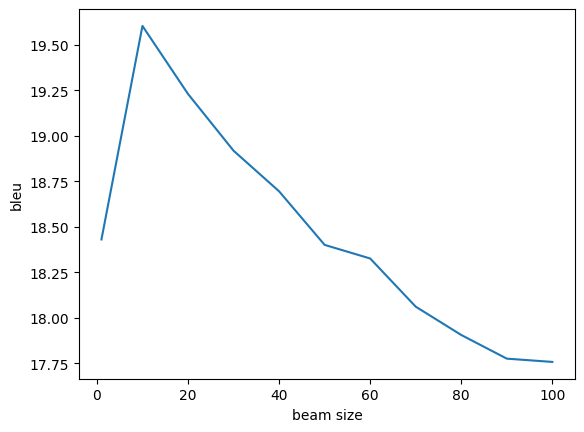

In [ ]:
import matplotlib.pyplot as plt

plt.plot(beam_sizes, [result['eval_bleu'] for result in results])
plt.xlabel('beam size')
plt.ylabel('bleu')
plt.show()

## 95 サブワード化

In [ ]:
sample_sentence = "I went to the woods because I wished to live deliberately."

tokenizer_BPE = AutoTokenizer.from_pretrained("roberta-base", return_tensors="pt")
tokenizer_wordpiece = AutoTokenizer.from_pretrained("distilbert-base-uncased", return_tensors="pt")
tokenizer_sentencepiece = AutoTokenizer.from_pretrained("t5-base", return_tensors="pt")

In [ ]:
inputs = tokenizer_BPE(sample_sentence)
print(tokenizer_BPE.convert_ids_to_tokens(inputs["input_ids"]))

#Ġ corresponds to spaces in byte-level BPE.

['<s>', 'I', 'Ġwent', 'Ġto', 'Ġthe', 'Ġwoods', 'Ġbecause', 'ĠI', 'Ġwished', 'Ġto', 'Ġlive', 'Ġdeliberately', '.', '</s>']


In [ ]:
inputs = tokenizer_wordpiece(sample_sentence)
print(tokenizer_wordpiece.convert_ids_to_tokens(inputs["input_ids"]))

['[CLS]', 'i', 'went', 'to', 'the', 'woods', 'because', 'i', 'wished', 'to', 'live', 'deliberately', '.', '[SEP]']


In [ ]:
inputs = tokenizer_sentencepiece(sample_sentence)
print(tokenizer_sentencepiece.convert_ids_to_tokens(inputs["input_ids"]))

['▁I', '▁went', '▁to', '▁the', '▁wood', 's', '▁because', '▁I', '▁', 'wished', '▁to', '▁live', '▁deliberately', '.', '</s>']


## 96 学習過程の可視化

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=73ac571b8663d4e20cbb73a9c691fadefb711391ff969e7429386d624ea52991
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%env WANDB_PROJECT=opus_mt_ja_en_wandb

env: WANDB_PROJECT=opus_mt_ja_en_wandb


In [ ]:
from transformers import AutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer

model_checkpoint = "Helsinki-NLP/opus-mt-ja-en"
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
args = Seq2SeqTrainingArguments(
    f"marian-finetuned-kftt-ja-to-en-wandb",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01, #for regularization (anti over-fitting)
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True, #predict by auto-regressive generation
    fp16=True,
    push_to_hub=True,
    report_to="wandb"
)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"].select(range(100)),
    eval_dataset={'Validation': tokenized_datasets["validation"].select(range(16)), 'Train': tokenized_datasets["train"].select(range(16))},
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/sephinroth/marian-finetuned-kftt-ja-to-en-wandb into local empty directory.


In [ ]:
#according to this issue: https://github.com/huggingface/transformers/issues/20565

from transformers.utils.notebook import NotebookProgressCallback
trainer.remove_callback(NotebookProgressCallback)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Adding files tracked by Git LFS: ['source.spm', 'target.spm']. This may take a bit of time if the files are large.


TrainOutput(global_step=70, training_loss=2.7923795427594866, metrics={'train_runtime': 422.0483, 'train_samples_per_second': 2.369, 'train_steps_per_second': 0.166, 'total_flos': 13730956443648.0, 'train_loss': 2.7923795427594866, 'epoch': 10.0})

In [ ]:
wandb.finish()

eval/Train_bleu,▁▃▆▆▇█▇▇██
eval/Train_loss,█▆▅▄▃▂▂▁▁▁
eval/Train_runtime,▇█▃▁▃▁▄▃▁▅
eval/Train_samples_per_second,▁▁▅█▄█▄▄█▃
eval/Train_steps_per_second,▁▁▅█▄█▄▄█▃
eval/Validation_bleu,▁▃▆█▆▇▅▃▅▅
eval/Validation_loss,█▅▄▃▂▂▁▁▁▁
eval/Validation_runtime,▁▃▁▂▁█▇█▇█
eval/Validation_samples_per_second,█▃▇▅▆▁▁▁▁▁
eval/Validation_steps_per_second,█▃▇▅▆▁▁▁▁▁
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███


![picture](https://drive.google.com/uc?export=view&id=12KDpOtS212ov9_K7LqBUYeC0kWZph87A)

![picture](https://drive.google.com/uc?export=view&id=1qxd0IORwPMc3NTMD6U5N51o8DvLFSTpZ)

## 98 ドメイン適応

In [ ]:
!mkdir -p data work

In [ ]:
!wget -P data -nc https://nlp.stanford.edu/projects/jesc/data/raw.tar.gz

--2023-07-27 08:19:31--  https://nlp.stanford.edu/projects/jesc/data/raw.tar.gz
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102198198 (97M) [application/x-gzip]
Saving to: ‘data/raw.tar.gz’

raw.tar.gz          100%[===================>]  97.46M  28.6MB/s    in 4.2s    

2023-07-27 08:19:35 (23.0 MB/s) - ‘data/raw.tar.gz’ saved [102198198/102198198]



In [ ]:
%%bash
cd data
tar -xzf raw.tar.gz

In [ ]:
!head "data/raw/raw"

you are back, aren't you, harold?	あなたは戻ったのね ハロルド?
my opponent is shark.	俺の相手は シャークだ。
this is one thing in exchange for another.	引き換えだ ある事とある物の
yeah, i'm fine.	もういいよ ごちそうさま ううん
don't come to the office anymore. don't call me either.	もう会社には来ないでくれ 電話もするな
looks beautiful.	きれいだ。
get him out of here, because i will fucking kill him.	連れて行け 殺しそうだ わかったか?
you killed him!	殺したのか!
okay, then who?	わぁ~! いつも すみません。 いいのよ~。
it seems a former employee...	カンパニーの元社員が


In [ ]:
with open('data/raw/raw') as fo:
  lines = fo.readlines()

In [ ]:
%pip install jsonlines
import jsonlines

In [ ]:
with jsonlines.open('work/jesc.jsonl', 'w') as writer:
  for line in lines:
    en, ja = line.strip('\n').split('\t')
    data = {'ja':ja, 'en':en}
    writer.write(data)

In [ ]:
jesc_dataset = load_dataset('json', data_files="work/jesc.jsonl")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
id = [i for i in range(jesc_dataset['train'].num_rows)]
jesc_dataset = jesc_dataset['train'].add_column('id', id)

In [ ]:
jesc_dataset[0]

{'ja': 'あなたは戻ったのね ハロルド?', 'en': "you are back, aren't you, harold?", 'id': 0}

In [ ]:
#tokenize the datasets

max_length = 128

def preprocess_function(examples):
    #print(examples['ja'])
    #print(examples['en'])
    model_inputs = tokenizer(
        examples['ja'], text_target=examples['en'], max_length=max_length, truncation=True
    )
    return model_inputs

jesc_dataset_tokenized = jesc_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=jesc_dataset.column_names,
)

Map:   0%|          | 0/2801388 [00:00<?, ? examples/s]

In [ ]:
import evaluate
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq

metric = evaluate.load("sacrebleu") #the Evaluate object will be used to compute sacrebleu scores

model_checkpoint = "sephinroth/marian-finetuned-kftt-ja-to-en"
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
#define the evaluation function, which will be used by the Trainer object

import numpy as np

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # In case the model returns more than the what we need
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True) #token to string

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True) #token to string

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels] #the metric is designed to accept several acceptable targets, so it should be a list of list of strings

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

In [ ]:
args = Seq2SeqTrainingArguments(
    f"marian-finetuned-kftt-ja-to-en-jesc",
    evaluation_strategy="no", #don't do evaluation during training
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01, #for regularization (anti over-fitting)
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True, #predict by auto-regressive generation
    fp16=True,
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=jesc_dataset_tokenized.select(range(100000)),
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/sephinroth/marian-finetuned-kftt-ja-to-en-jesc into local empty directory.


In [ ]:
trainer.evaluate(max_length=max_length)

{'eval_loss': 1.823565125465393,
 'eval_bleu': 20.454677588521438,
 'eval_runtime': 136.541,
 'eval_samples_per_second': 8.503,
 'eval_steps_per_second': 0.139}

In [ ]:
trainer.train()
trainer.evaluate(max_length=max_length)
trainer.push_to_hub(tags="translation", commit_message="Training complete")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,2.761000
1000,2.628500
1500,2.565000
2000,2.545100
2500,2.517100
3000,2.522900


Adding files tracked by Git LFS: ['source.spm', 'target.spm']. This may take a bit of time if the files are large.


To https://huggingface.co/sephinroth/marian-finetuned-kftt-ja-to-en-jesc
   a7e37ed..a5dcccc  main -> main

   a7e37ed..a5dcccc  main -> main

To https://huggingface.co/sephinroth/marian-finetuned-kftt-ja-to-en-jesc
   a5dcccc..28789cd  main -> main

   a5dcccc..28789cd  main -> main



'https://huggingface.co/sephinroth/marian-finetuned-kftt-ja-to-en-jesc/commit/a5dccccfde8461241918262dc3565b93ef1cb48c'

In [ ]:
trainer.evaluate(max_length=max_length)

{'eval_loss': 2.552680015563965,
 'eval_bleu': 10.183271801052467,
 'eval_runtime': 120.5116,
 'eval_samples_per_second': 9.634,
 'eval_steps_per_second': 0.158,
 'epoch': 1.0}

## 97 ハイパー・パラメータの調整

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: clovis-zhu. Use `wandb login --relogin` to force relogin


True

In [ ]:
%env WANDB_PROJECT=opus_mt_ja_en_hyper

env: WANDB_PROJECT=opus_mt_ja_en_hyper


In [ ]:
model_checkpoint = 'Helsinki-NLP/opus-mt-ja-en'

def model_init():
  model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).to("cuda")
  return model

In [ ]:
# method
sweep_config = {
    'method': 'random'
}

# hyperparameters
parameters_dict = {
    'epochs': {
        'value': 1
        },
    'learning_rate': {
        'distribution': 'log_uniform_values',
        'min': 1e-5,
        'max': 1e-3
    },
    'weight_decay': {
        'values': [0.0, 0.01, 0.05, 0.1, 0.2]
    },
}

sweep_config['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='opus_mt_ja_en_hyper')

Create sweep with ID: y3tftzd4
Sweep URL: https://wandb.ai/clovis-zhu/opus_mt_ja_en_hyper/sweeps/y3tftzd4


In [ ]:
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer

def train(config=None):
  with wandb.init(config=config):
    # set sweep configuration
    config = wandb.config

    # set training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir='opus_mt_ja_en_hyper',
        report_to='wandb',  # Turn on Weights & Biases logging
        num_train_epochs=config.epochs,
        learning_rate=config.learning_rate,
        weight_decay=config.weight_decay,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=16,
        save_strategy='epoch',
        evaluation_strategy='epoch',
        logging_strategy='epoch',
        load_best_model_at_end=True,
        remove_unused_columns=False,
        predict_with_generate=True,
        push_to_hub=False,
        fp16=True
    )

    # define training loop
    trainer = Seq2SeqTrainer(
        # model,
        model_init=model_init,
        args=training_args,
        data_collator=data_collator,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['validation'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # start training loop
    trainer.train()

In [ ]:
wandb.agent(sweep_id, train, count=10)

wandb: Agent Starting Run: g5fidqiy with config:
wandb: 	epochs: 1
wandb: 	learning_rate: 0.0006157281133510774
wandb: 	weight_decay: 0.1


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Bleu
1,2.522600,1.938666,18.925117


eval/bleu,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁
train/loss,▁
train/total_flos,▁
train/train_loss,▁


wandb: Agent Starting Run: t6g8uxc0 with config:
wandb: 	epochs: 1
wandb: 	learning_rate: 3.195551386446208e-05
wandb: 	weight_decay: 0.05


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Bleu
1,2.464700,2.071487,18.479092


eval/bleu,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁
train/loss,▁
train/total_flos,▁
train/train_loss,▁


wandb: Agent Starting Run: lx1384t1 with config:
wandb: 	epochs: 1
wandb: 	learning_rate: 5.199811042585143e-05
wandb: 	weight_decay: 0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Bleu
1,2.331700,1.982563,19.064659


eval/bleu,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁
train/loss,▁
train/total_flos,▁
train/train_loss,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bl9bp6bs with config:
wandb: 	epochs: 1
wandb: 	learning_rate: 0.000471768380778716
wandb: 	weight_decay: 0.2


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Bleu
1,2.368600,1.866791,19.585839


eval/bleu,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁
train/loss,▁
train/total_flos,▁
train/train_loss,▁


wandb: Agent Starting Run: x1hwjx0q with config:
wandb: 	epochs: 1
wandb: 	learning_rate: 1.1233670859883755e-05
wandb: 	weight_decay: 0.2


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Bleu
1,2.838500,2.381618,15.740364


eval/bleu,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁
train/loss,▁
train/total_flos,▁
train/train_loss,▁


wandb: Agent Starting Run: u0wuqqlb with config:
wandb: 	epochs: 1
wandb: 	learning_rate: 6.182627581782306e-05
wandb: 	weight_decay: 0.2


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Bleu
1,2.269800,1.936704,19.333090


eval/bleu,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁
train/loss,▁
train/total_flos,▁
train/train_loss,▁


wandb: Agent Starting Run: hdwx49pq with config:
wandb: 	epochs: 1
wandb: 	learning_rate: 0.0008750326206244982
wandb: 	weight_decay: 0.05


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Bleu
1,2.981000,2.231879,15.829912


eval/bleu,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁
train/loss,▁
train/total_flos,▁
train/train_loss,▁


wandb: Agent Starting Run: 70pct2vz with config:
wandb: 	epochs: 1
wandb: 	learning_rate: 0.0001576872890594452
wandb: 	weight_decay: 0.01


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss


![picture](https://drive.google.com/uc?export=view&id=167rR8LyZUCEfEx2q12T44cCSxAQrZQi3)

![picture](https://drive.google.com/uc?export=view&id=1qxd0IORwPMc3NTMD6U5N51o8DvLFSTpZ)

## 99 翻訳サーバの構築